# NLP Project

Kaggle competition "Real or Not? NLP with Disaster Tweets". We'll use the (leaked) test labels only to evaluate our model in the end.  
First we import some standard packages and read the data.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')
test_labels = pd.read_csv("submission.csv", index_col='id')

The training data is roughly balanced.

([<matplotlib.axis.XTick at 0x21ac4b7e808>,
 <a list of 2 Text xticklabel objects>)

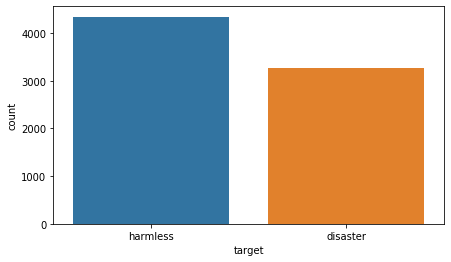

In [46]:
plt.figure(figsize=(7,4))
sns.countplot(x=train.target)
plt.xticks([0,1], ['harmless', 'disaster'])

Let's check for null entries:

In [10]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(1), object(3)
memory usage: 617.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 3 columns):
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: object(3)
memory usage: 102.0+ KB


(None, None)

The location column does not contain enough entries, so we're not going to use it. To preprocess the text data, we can do the following:
- add the keyword as first word of the text
- remove all urls by dropping everything that starts with 'http'
- replace '%20' by blank and '&amp' by 'and'
- drop all non-alphabetic characters like numbers and punctuation
- use a tweet tokenizer to drop #-handles, convert to lowercase, and reduce to at most three identitcal letters in a row
- stem and remove stopwords

All of the above is done by the function clean(data). After cleaning, a few tweets will become identical, so we drop duplicates. 

In [70]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

def clean(data):
    df=data.copy()
    df['keyword'].fillna('', inplace=True)
    df['keyword'] = df['keyword'].str.replace('%20', ' ')
    df['text'] = df['keyword']+' '+df['text']
    df['text'] = df['text'].str.replace(r'http\S+', ' ')
    df['text'] = df['text'].str.replace('&amp', ' and ')
    df['text'] = df['text'].str.replace(r'[^a-zA-Z]', ' ')
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
#    df['text'] = df['text'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))
    return df

df=clean(train)
df = df.drop_duplicates(subset='text')
X = df['text']
y = df['target']

X_test = clean(test)['text']
y_test = test_labels['target']

Now the tweets look like this: 

In [71]:
X.head()

id
1         deeds reason earthquake may allah forgive us
4                forest fire near la ronge sask canada
5    residents asked shelter place notified officer...
6    people receive wildfires evacuation orders cal...
7    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

Next we'd like to keep track of word appearances. For this, we count how often a word occurs in a harmless or disastrous tweet and store the count in a new dataframe wordcount. 



In [72]:
from collections import defaultdict

freq_dict_1 = defaultdict(int)
for row in df['text'][df['target']==1]:
    for word in row.split():
        freq_dict_1[word] += 1
        
freq_dict_0 = defaultdict(int)
for row in df['text'][df['target']==0]:
    for word in row.split():
        freq_dict_0[word] += 1 
        
vocabulary = set(freq_dict_0.keys()).union(set(freq_dict_1.keys()))

wordcount = pd.DataFrame(list(vocabulary), columns= ["word"])
wordcount['disaster'] = wordcount['word'].apply(lambda x: freq_dict_1[x])
wordcount['harmless'] = wordcount['word'].apply(lambda x: freq_dict_0[x])
wordcount['total_count'] = wordcount['disaster']+wordcount['harmless']
wordcount.sort_values(by='total_count', ascending=False, inplace=True)
wordcount.set_index('word', inplace=True)


In [74]:
wordcount

,disaster,harmless,total_count
word,,,
fire,244,113,357
like,91,248,339
emergency,141,156,297
disaster,155,74,229
burning,118,108,226
...,...,...,...
halljh,1,0,1
gio,0,1,1
rivals,0,1,1


Let's see what the most frequent words in harmless vs. disaster tweets are.

Text(0.5, 1.0, '30 most common words in disaster tweets')

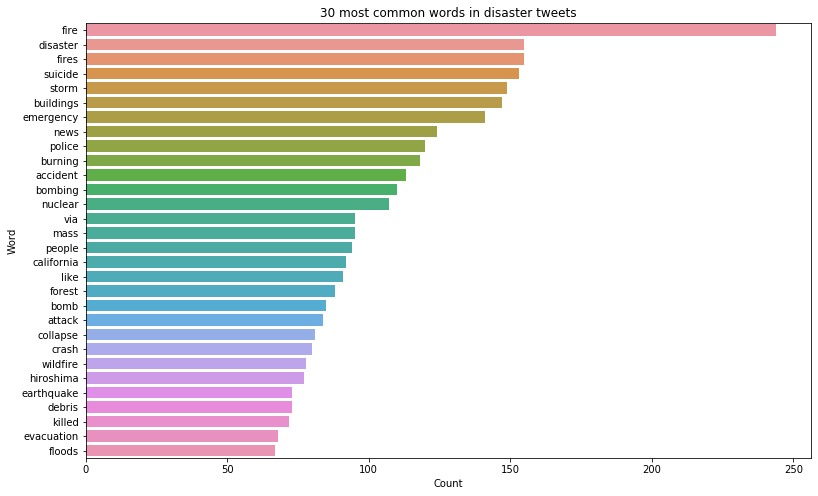

In [75]:
plt.figure(figsize=(13,8))
sns.barplot(x=wordcount['disaster'].sort_values(ascending=False).iloc[:30], y=wordcount.sort_values(by='disaster', ascending=False).index[:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('30 most common words in disaster tweets')

Text(0.5, 1.0, '30 most common words in harmless tweets')

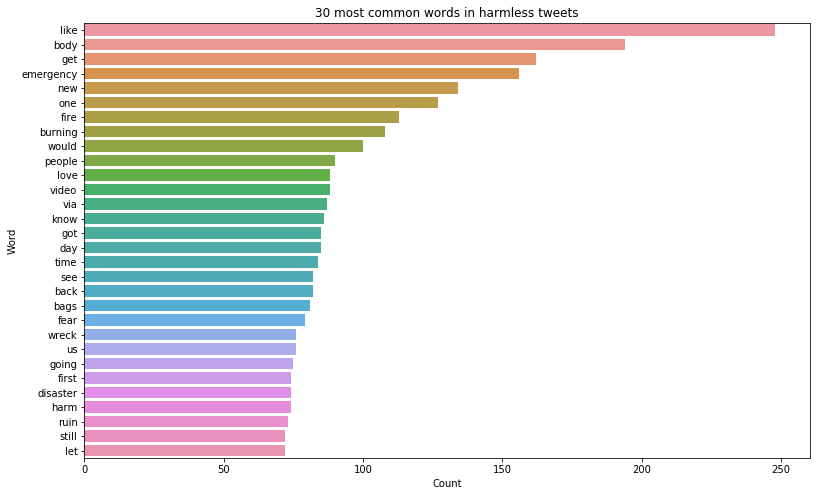

In [76]:
plt.figure(figsize=(13,8))
sns.barplot(x=wordcount['harmless'].sort_values(ascending=False).iloc[:30], y=wordcount.sort_values(by='harmless', ascending=False).index[:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('30 most common words in harmless tweets')

Then we remove all words that occur less than 5 times in total from the tweets. Some tweets will become empty strings, so we drop these from X and y and update the vocabulary.

In [77]:
minimal_occurrences = 5
X=X.apply(lambda x: ' '.join([word for word in x.split() if wordcount['total_count'][word]>=minimal_occurrences]))
X=X[X.str.split().apply(len)>0]
y=y[X.index]
wordcount = wordcount[wordcount['total_count']>=minimal_occurrences]
new_vocabulary = set(wordcount.index)


Let's see how many words we've dropped.

In [78]:
print('Length of old vocabulary: {}'.format(len(vocabulary)))
print('Length of new vocabulary: {}'.format(len(new_vocabulary)))

Length of old vocabulary: 16068
Length of new vocabulary: 2453


It's time to vectorize. We first use the count vectorizer, which encodes each tweet as a vector, where the entry at each word is the number of occurrences of this word in the tweet. We can do the same for the tf-idf (term frequency * inverse document frequency) vectorizer, which normalizes the counts by the total number of tweets in which the word occurs. 

We can also adjust the n-gram range to include entries for tuples of words. For example, ngram_range=(1,2) considers words and pairs of words.

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


#vectorizer = CountVectorizer(ngram_range=(1,1))
vectorizer = TfidfVectorizer(ngram_range=(1,1))

train_vectors = vectorizer.fit_transform(X)
test_vectors = vectorizer.transform(X_test)

Now we split the data into a train and validation set. Since the vectors are sparse matrices, we won't apply scaling. 

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_vectors, y, test_size=0.2, shuffle=True, stratify=y)

Having vectorized the tweets, we can project the vectors down to two dimensions using singular value decomposition (SVD). 
We plot the two-dimensional projections of harmless tweets as yellow dots and of disaster tweets as red dots. Unfortunately (or expectedly), the red and yellow dots don't seem to be well separated.  

Text(0.5, 1.0, '2D-projections of vectorized tweets')

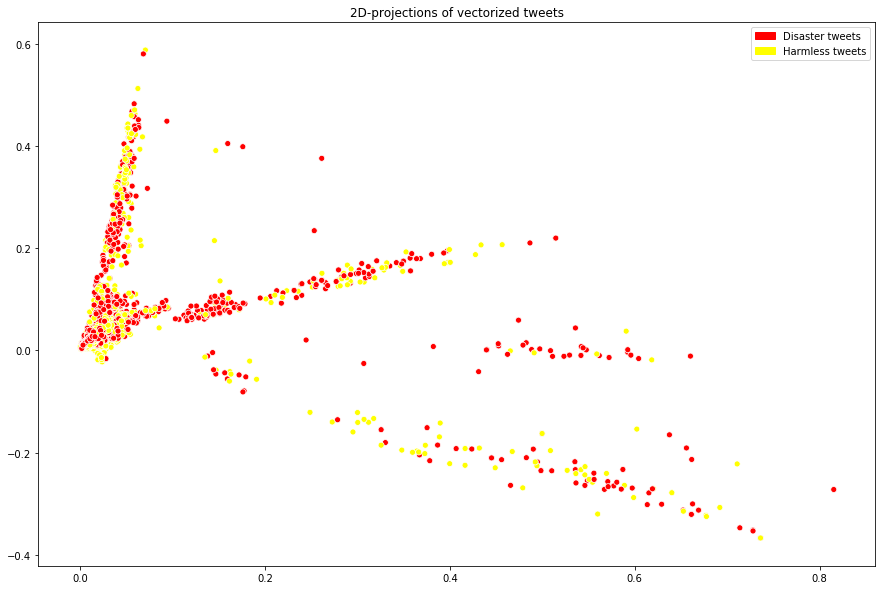

In [84]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

plt.figure(figsize=(15,10))
svd = TruncatedSVD(n_components=2)
projected_train_vectors = svd.fit_transform(train_vectors)
sns.scatterplot(x=projected_train_vectors[:,0], y=projected_train_vectors[:,1], hue=y, palette={0:'yellow', 1:'red'}, legend=False)
red_patch = mpatches.Patch(color='red', label='Disaster tweets')
yellow_patch = mpatches.Patch(color='yellow', label='Harmless tweets')
plt.legend(handles=[red_patch, yellow_patch])
plt.title('2D-projections of vectorized tweets')

Now we test several classifiers and see which one performs best. Performance in the competition was evaluated by F1-score.

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

model_parameters = {
LogisticRegression() : {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100] }, 
KNeighborsClassifier(): {'n_neighbors': [3,5,7], 'weights': ['uniform', 'distance']},
RandomForestClassifier(): {'n_estimators':[50, 75, 100], 'min_samples_leaf': [4,8]}  
#, SVC() : {'gamma': ['auto'], 'C':[0.1, 1, 10] , 'kernel': ['rbf', 'poly']}
}

max_score = 0

for model in model_parameters.keys():
    grid_search = GridSearchCV(model, model_parameters[model], verbose=0, cv=5)
    grid_search.fit(X_train, y_train)
    clf = grid_search.best_estimator_
    training_score = f1_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_val)
    validation_score = f1_score(y_pred, y_val)
    if score > max_score:
        best_clf = clf
        max_score = score
    print('Best score on training set: {}'.format(training_score ))
    print('Score of best estimator on validation set: {}'.format(validation_score))

C:\Users\steff\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best score on training set: 0.7952038369304556
Best score on validation set: 0.7328833172613308
Best score on training set: 0.9919821826280623
Best score on validation set: 0.6796116504854368
Best score on training set: 0.8028525419829768
Best score on validation set: 0.7047619047619048


Logistic regression seems to give the best score. We can do a grid search to tweak the hyperparameters a little more. 

In [90]:
best_clf

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Finally, let's see how well the model performs on the test set.

In [91]:
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(test_vectors)
print('F1-score: {}%'.format(round(100*f1_score(y_test, y_pred),2)))
print('Accuracy-score: {}%'.format(round(100*accuracy_score(y_test, y_pred),2)))



F1-score: 71.74%
Accuracy-score: 78.03%
